In [ ]:
import sys
import math
import random
import warnings
import numpy as np
from sklearn import svm
import keras.backend as K
from keras.models import Model
from theano import tensor as T
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, Add
from keras.engine.topology import Layer
from sklearn.metrics import accuracy_score
from keras.layers.core import  Activation, Dense, Reshape
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten

In [ ]:
warnings.simplefilter("ignore")

HIDDEN_DIM_1 = 500
HIDDEN_DIM_2 = 300
HIDDEN_DIM_3 = 50      
EPOCHS = 100
BATCH_SIZE = 100
IMG_DIM = 392         
LAMBDA_1 = 0.02
LAMBDA_2 = 0.001
LAMBDA_3 = 0.05
H_LOSS = 50

In [ ]:
def svm_(train_x, train_y, test_x, test_y):
    
    clf = svm.LinearSVC()
    clf.fit(train_x,train_y)
    
    pred = clf.predict(test_x)
    return accuracy_score(np.ravel(test_y),np.ravel(pred))

In [ ]:
class ZeroPadding(Layer):
    def __init__(self, **kwargs):
        super(ZeroPadding, self).__init__(**kwargs)

    def call(self, x, mask=None):
        return K.zeros_like(x)

    def get_output_shape_for(self, input_shape):
        return input_shape

In [ ]:
class CorrnetCost(Layer):
    def __init__(self, LAMBDA, **kwargs):
        super(CorrnetCost, self).__init__(**kwargs)
        self.LAMBDA = LAMBDA

    def call(self, x ,mask=None):
        y1_centered = x[0] - K.mean(x[0], axis=0)
        y2_centered = x[1] - K.mean(x[1], axis=0)
        corr_dr = K.sqrt(K.sum(y1_centered * y1_centered, axis=0) + 1e-8) * K.sqrt(K.sum(y2_centered * y2_centered, axis=0) + 1e-8)
        return K.sum((K.sum(y1_centered * y2_centered, axis=0)) / corr_dr) * self.LAMBDA

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0],input_shape[0][1])

def corr_loss(y_true, y_pred):
    return y_pred

In [ ]:
def test(test_left, test_right, labels):
    acc = 0
    parts = 5
    batches = (len(test_left) // parts)

    for i in range(parts):
        print(int(i*batches), ' to ', int((i+1)*batches))
        
        test_x = test_right[int(i*batches):int((i+1)*batches)]
        test_y = labels[i*batches:(i+1)*batches]
        
        train_x = np.concatenate((test_left[0:i*batches],test_left[(i+1)*batches:len(test_left)]))
        train_y = np.concatenate((labels[0:i*batches],labels[(i+1)*batches:len(test_left)]))

        acc += svm_(train_x, train_y, test_x, test_y)

    return(100 * (acc/parts))

In [ ]:
def get_model():
  
    inpx = Input(shape=(IMG_DIM,))
    inpy = Input(shape=(IMG_DIM,))

    hx = Reshape((28,14,1))(inpx)
    hx = Conv2D(128, (3, 3), activation='relu', padding='same')(hx)
    hx = MaxPooling2D((2, 2), padding='same')(hx)
    hx = Conv2D(64, (3, 3), activation='relu', padding='same')(hx)
    hx = MaxPooling2D((2, 2), padding='same')(hx)
    hx = Conv2D(49, (3, 3), activation='relu', padding='same')(hx)
    hx = MaxPooling2D((2, 2), padding='same')(hx)
    hx = Flatten()(hx)
    hidden_out_x1 = Dense(HIDDEN_DIM_1,activation='sigmoid')(hx)
    hidden_out_x2 = Dense(HIDDEN_DIM_2, activation='sigmoid',name='hid_l1')(hidden_out_x1)
    hidden_out_x3 = Dense(HIDDEN_DIM_3, activation='sigmoid',name='hid_l')(hidden_out_x2)

    hy = Reshape((28,14,1))(inpy)
    hy = Conv2D(128, (3, 3), activation='relu', padding='same')(hy)
    hy = MaxPooling2D((2, 2), padding='same')(hy)
    hy = Conv2D(64, (3, 3), activation='relu', padding='same')(hy)
    hy = MaxPooling2D((2, 2), padding='same')(hy)
    hy = Conv2D(49, (3, 3), activation='relu', padding='same')(hy)
    hy = MaxPooling2D((2, 2), padding='same')(hy)
    hy = Flatten()(hy)
    hidden_out_y1 = Dense(HIDDEN_DIM_1, activation='sigmoid')(hy)
    hidden_out_y2 = Dense(HIDDEN_DIM_2, activation='sigmoid',name='hid_r1')(hidden_out_y1)
    hidden_out_y3 = Dense(HIDDEN_DIM_3, activation='sigmoid',name='hid_r')(hidden_out_y2)

    combined_out =  Add()([hidden_out_x3,hidden_out_y3]) 
    
    recx = Dense(IMG_DIM)(combined_out)
    recy = Dense(IMG_DIM)(combined_out)
    
    intermediate_model = Model([inpx,inpy],[recx,recy,combined_out,hidden_out_x1,hidden_out_y1,hidden_out_x2,hidden_out_y2])

    [recx1,recy1,h1,_,_,_,_] = intermediate_model([inpx, ZeroPadding()(inpy)])
    [recx2,recy2,h2,_,_,_,_] = intermediate_model([ZeroPadding()(inpx), inpy ])
    [recx3,recy3,h3,hx_1,hy_1,hx_2,hy_2] = intermediate_model([inpx, inpy])
    
    corr1 = CorrnetCost(-LAMBDA_1)([h1,h2])
    corr2 = CorrnetCost(-LAMBDA_2)([hx_1,hy_1])
    corr3 = CorrnetCost(-LAMBDA_3)([hx_2,hy_2])
    
    model = Model([inpx,inpy],[recy1,recx2,recx1,recy2,corr1,corr2,corr3])
    model.compile(loss=["mse","mse","mse","mse",corr_loss,corr_loss,corr_loss],optimizer="rmsprop")

    return model, intermediate_model

In [ ]:
def get_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    X_train_l = x_train[:, :, :14]
    X_train_r = x_train[:, :, 14:]
    X_test_l = x_test[:, :, :14]
    X_test_r = x_test[:, :, 14:]
    
    return X_train_l, X_train_r, y_train, X_test_l, X_test_r, y_test

In [ ]:
def visualize(left_view, right_view, y_train):

  for i in range(4):
    plt.subplot(1, 2, 1)
    left = left_view[i]
    pixels = np.array(left, dtype='uint8')
    pixels = pixels.reshape((28, 14))
    plt.title('Label is {label}'.format(label=y_train[i]))
    plt.imshow(pixels, cmap='gray')

    plt.subplot(1, 2, 2)
    right = right_view[i]
    pixels = np.array(right, dtype='uint8')
    pixels = pixels.reshape((28, 14))
    plt.title('Label is {label}'.format(label=y_train[i]))
    plt.imshow(pixels, cmap='gray')

    plt.show()

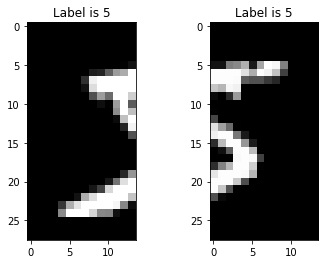

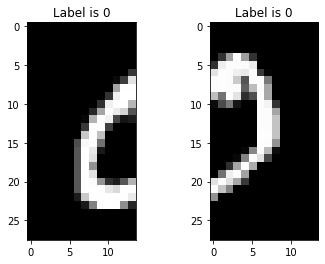

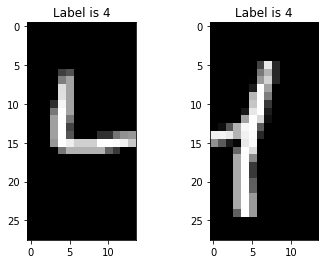

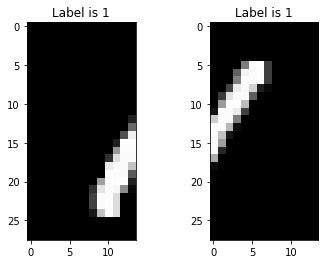

In [ ]:
train_left, train_right, y_train, test_left, test_right, y_test = get_data()

visualize(train_left, train_right, y_train)

In [ ]:
train_left = train_left.reshape(-1, IMG_DIM)
train_right = train_right.reshape(-1, IMG_DIM)

test_left = test_left.reshape(-1, IMG_DIM)
test_right = test_right.reshape(-1, IMG_DIM)

In [ ]:
model, intermediate_model = get_model()

model.fit([train_left,train_right], [train_right,train_left,train_left,train_right,
              np.zeros((train_left.shape[0],H_LOSS)), np.zeros((train_left.shape[0],HIDDEN_DIM_1)),np.zeros((train_left.shape[0],HIDDEN_DIM_2))],
              epochs = EPOCHS, batch_size = BATCH_SIZE, verbose=1)

Epoch 1/100
600/600 [==============================] - 50s 77ms/step - loss: 25663.6892 - model_6_loss: 7100.4780 - model_6_1_loss: 5738.2117 - model_6_2_loss: 5738.2049 - model_6_3_loss: 7100.4746 - corrnet_cost_9_loss: -0.7889 - corrnet_cost_10_loss: -0.0755 - corrnet_cost_11_loss: -12.8167
Epoch 2/100
600/600 [==============================] - 46s 77ms/step - loss: 18508.1801 - model_6_loss: 5023.8408 - model_6_1_loss: 4243.0031 - model_6_2_loss: 4238.0314 - model_6_3_loss: 5017.7505 - corrnet_cost_9_loss: -0.8029 - corrnet_cost_10_loss: -0.1875 - corrnet_cost_11_loss: -13.4526
Epoch 3/100
600/600 [==============================] - 46s 77ms/step - loss: 16955.5601 - model_6_loss: 4542.3843 - model_6_1_loss: 3969.0331 - model_6_2_loss: 3944.4619 - model_6_3_loss: 4512.9038 - corrnet_cost_9_loss: -0.7945 - corrnet_cost_10_loss: -0.1769 - corrnet_cost_11_loss: -12.2503
Epoch 4/100
600/600 [==============================] - 46s 76ms/step - loss: 16728.1304 - model_6_loss: 4474.8036 - mo

In [ ]:
test_left = intermediate_model.predict([test_left, np.zeros_like(test_left)])[2]
test_right = intermediate_model.predict([np.zeros_like(test_right), test_right])[2] 

print("Left to Right: ")
print("Accuracy = ", test(test_left, test_right, y_test))

print("Right to Left: ")
print("Accuracy = ", test(test_right, test_left, y_test))

Left to Right: 
0  to  2000
2000  to  4000
4000  to  6000
6000  to  8000
8000  to  10000
Accuracy =  83.14
Right to Left: 
0  to  2000
2000  to  4000
4000  to  6000
6000  to  8000
8000  to  10000
Accuracy =  83.35000000000001
